# CNN for Fluo Classification

### Install Dependencies

In [1]:
%matplotlib inline

In [2]:
!pip install mxnet-cu101
!pip install gluoncv

In [3]:
import mxnet as mx
import numpy as np
import os, time, shutil
import matplotlib.pyplot as plt
from PIL import Image

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs
from gluoncv.model_zoo import get_model

### Mount Google Drive

In [4]:
import os
from google.colab import files, drive   
import pandas as pd

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/My Drive/cs101'
print(os.listdir(home_path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['video_fluo_data', 'video_bf_data', 'processed', 'video_data_time_info_CS101.xlsx', 'ResNet50_v2-finetune-data_aug-order-random-dataaug.params', 'CS 101 Weekly Notes.gslides']


### Get Data

In [5]:
# Fixing the random seed
mx.random.seed(42)
np.random.seed(42)

# Available data
embryo_inds = [1, 3, 12, 13, 16, 18, 19, 24, 39, 40, 42, 45, 46, 47, 49, 50, 52, 53]

# Load info about videos
video_time_info = pd.read_excel(f'{home_path}/video_data_time_info_CS101.xlsx', index_col=0, header=0, na_values=['NaN','NAN'], usecols=['usable_index', 'first_pol_time', 't_num'])  
video_time_info.dropna(inplace=True, subset=['first_pol_time'])
print(video_time_info.loc[embryo_inds])

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

p = np.random.permutation(len(embryo_inds))
p_embryo = [embryo_inds[i] for i in p]
t_num = list(video_time_info.loc[embryo_inds, 't_num'])
t_num_random = list(video_time_info.loc[p_embryo, 't_num'])

instance_cum_random = np.cumsum(t_num_random)
test_split_point = instance_cum_random[-1]*0.83
temp = abs(instance_cum_random-test_split_point)
test_idx = np.argmin(temp)

val_split_point = instance_cum_random[-1]*0.7
temp = abs(instance_cum_random-val_split_point)
val_idx = np.argmin(temp)


train_embryos = p_embryo[:val_idx]
val_embryos = p_embryo[val_idx:test_idx]
test_embryos = p_embryo[test_idx:]
print(train_embryos)
print(val_embryos)
print(test_embryos)

data_path = f'{processed_path}/fluo_data/middle'
pol_path = f'{processed_path}/polarization'
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'val')
test_path = os.path.join(data_path, 'test')

              first_pol_time  t_num
usable_index                       
1                       17.0   21.0
3                       12.0   21.0
12                      11.0  143.0
13                      12.0  143.0
16                      30.0  143.0
18                      27.0  143.0
19                      32.0  143.0
24                      20.0   21.0
39                      12.0   21.0
40                       8.0   21.0
42                      16.0   21.0
45                      19.0   21.0
46                      19.0   21.0
47                      17.0   21.0
49                      21.0   21.0
50                      21.0   21.0
52                      13.0   21.0
53                      20.0   21.0
[1, 3, 39, 18, 13, 47, 52, 50, 45, 12, 40, 53]
[16, 46, 24]
[42, 49, 19]


### Save NP Data as PNG for Training

In [6]:
# Actually create the images

def within_window(embryo_idx, t, window):
    '''
    embryo_idx: index of current embryo (value from 'usable_index' col)
    t: timestep of current
    window: number of t steps from first polarized index to ignore
    '''
    first_pol_idx = video_time_info.loc[embryo_idx, 'first_pol_time'] - 1
    return window and abs(first_pol_idx - t) <= window

def save_nps_as_png(embryos, save_path, window=None):
    '''
    embryos: subset of p_embryo... train, val, test
    save_path: path to save png to... data_path + {'train', 'val', 'test'}
    window: number of t steps from first polarized index to ignore
    '''
    for i in range(len(embryos)):
        embryo_idx = embryos[i]
        embryo_path = f'{data_path}/embryo_{embryo_idx}.npy'
        embryo_pol_path = f'{pol_path}/embryo_{embryo_idx}.npy'
        embryo = np.load(embryo_path)
        embryo_pol = np.squeeze(np.load(embryo_pol_path)).astype(int)
        embryo = embryo.astype(np.float64) / np.max(embryo) # normalize the data to 0 - 1
        embryo = 255 * embryo # Now scale by 255
        embryo = embryo.astype(np.uint8)
        print(embryo_idx, np.shape(embryo)[2])
        for t in range(np.shape(embryo)[2]):
            if within_window(embryo_idx, t, window):
                print(f'skipping embryo {embryo_idx} step {t}')
                continue
            pol = embryo_pol[t]
            img = Image.fromarray(embryo[:,:,t], 'L')
            img_path = f'{save_path}/{pol}/embryo_{embryo_idx}_{t}.png'
            img.save(img_path)

save_nps_as_png(train_embryos, train_path, window=None)
save_nps_as_png(val_embryos, val_path, window=None)
save_nps_as_png(test_embryos, test_path, window=None)

1 21
3 21
39 21
18 143
13 143
47 21
52 21
50 21
45 21
12 143
40 21
53 21
16 143
46 21
24 21
42 21
49 21
19 143


### Set Hyperparameters

In [14]:
# classes = 10
classes = 1

epochs = 15
lr = 0.001
per_device_batch_size = 16
momentum = 0.9
wd = 0.0001

lr_factor = 0.75
lr_steps = [10, 20, 30, np.inf]

num_gpus = 1
num_workers = 8
ctx = [mx.gpu(i) for i in range(num_gpus)] if num_gpus > 0 else [mx.cpu()]
batch_size = per_device_batch_size * max(num_gpus, 1)
print(ctx)

[gpu(0)]


Things to keep in mind:

1. ``epochs = 5`` is just for this tutorial with the tiny dataset. please change it to a larger number in your experiments, for instance 40.
2. ``per_device_batch_size`` is also set to a small number. In your experiments you can try larger number like 64.
3. remember to tune ``num_gpus`` and ``num_workers`` according to your machine.
4. A pre-trained model is already in a pretty good status. So we can start with a small ``lr``.

### Data Augmentation

In transfer learning, data augmentation can also help.
We use the following augmentation in training:

2. Randomly crop the image and resize it to 224x224
3. Randomly flip the image horizontally
4. Randomly jitter color and add noise
5. Transpose the data from height*width*num_channels to num_channels*height*width, and map values from [0, 255] to [0, 1]
6. Normalize with the mean and standard deviation from the ImageNet dataset.




In [15]:
transform_train = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),

    transforms.RandomFlipLeftRight(), # Randomly flip the image horizontally
    transforms.RandomFlipTopBottom(),
    transforms.RandomLighting(0.1), # Add AlexNet-style PCA-based noise to an image
    transforms.RandomContrast(0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(600, keep_ratio=True),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Data Loaders

With the data augmentation functions, we can define our data loaders:



In [16]:
train_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(val_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers = num_workers)

test_data = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(test_path).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers = num_workers)

print(len(train_data), len(val_data), len(test_data))

39 12 12


Note that only ``train_data`` uses ``transform_train``, while
``val_data`` and ``test_data`` use ``transform_test`` to produce deterministic
results for evaluation.

## Training

### Define Model

Simple CNN for now

In [17]:
import mxnet.ndarray as F

class Net(gluon.Block):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.conv1 = nn.Conv2D(20, kernel_size=(5,5))
            self.pool1 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.conv2 = nn.Conv2D(50, kernel_size=(5,5))
            self.pool2 = nn.MaxPool2D(pool_size=(2,2), strides = (2,2))
            self.fc1 = nn.Dense(500)
            # self.fc2 = nn.Dense(10)
            self.fc2 = nn.Dense(classes)

    def forward(self, x):
        x = self.pool1(F.tanh(self.conv1(x)))
        x = self.pool2(F.tanh(self.conv2(x)))
        # 0 means copy over size from corresponding dimension.
        # -1 means infer size from the rest of dimensions.
        x = x.reshape((0, -1))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        # x = F.sigmoid(self.fc2(x))
        # x = F.softmax(self.fc2(x))
        return x

### Initialize Model, Parameters, Trainer

In [18]:
net = Net()
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

optimizer = 'sgd' # 'nag': Nesterov accelerated gradient descent
optimizer_params = {'learning_rate': lr, 'wd': wd, 'momentum': momentum} # Set parameters

trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

### Define Evaluation Function for Test/Val Accuracy

Source: https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

In [19]:
metric = mx.metric.Accuracy()
# softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
# cross_entropy_loss = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
# cross_entropy_loss = gluon.loss.L2Loss()

def test(net, val_data, ctx):
    test_metric = mx.metric.Accuracy()

    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        test_metric.update(label, outputs)

    return test_metric.get()

### Training Loop

Following is the main training loop. It is the same as the loop in
`CIFAR10 <dive_deep_cifar10.html>`__
and ImageNet.

In [20]:
lr_counter = 0
num_batch = len(train_data)
train_acc_lst = []
train_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    if epoch == lr_steps[lr_counter]:
        trainer.set_learning_rate(trainer.learning_rate*lr_factor)
        lr_counter += 1

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            outputs = [net(X) for X in data]
            if epoch == 5:
                # print(list(zip(outputs, label)))
                print([(yhat, y, cross_entropy_loss(yhat, y)) for yhat, y in zip(outputs, label)])
            loss = [cross_entropy_loss(yhat, y) for yhat, y in zip(outputs, label)]
        for l in loss:
            l.backward()

        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)
        # print(loss)
        # train_loss += sum(loss) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch

    _, val_acc = test(net, val_data, ctx)

    train_acc_lst.append(train_acc)
    train_loss_lst.append(train_loss)
    val_acc_lst.append(val_acc)
    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

_, test_acc = test(net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Epoch 0] Train-acc: 0.286, loss: 0.000 | Val-acc: 0.357 | time: 23.2
[Epoch 1] Train-acc: 0.286, loss: 0.000 | Val-acc: 0.357 | time: 18.3
[Epoch 2] Train-acc: 0.286, loss: 0.000 | Val-acc: 0.357 | time: 18.1
[Epoch 3] Train-acc: 0.286, loss: 0.000 | Val-acc: 0.357 | time: 18.3
[Epoch 4] Train-acc: 0.286, loss: 0.000 | Val-acc: 0.357 | time: 18.3
[(
[[0.6634605 ]
 [0.6539102 ]
 [0.6598867 ]
 [0.6717908 ]
 [0.6684728 ]
 [0.65631974]
 [0.6546898 ]
 [0.65419745]
 [0.6637029 ]
 [0.6701911 ]
 [0.65127075]
 [0.6499107 ]
 [0.65070915]
 [0.6674865 ]
 [0.6768578 ]
 [0.6514913 ]]
<NDArray 16x1 @gpu(0)>, 
[0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1]
<NDArray 16 @gpu(0)>, 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
<NDArray 16 @gpu(0)>)]
[(
[[0.6530279 ]
 [0.66435087]
 [0.67226857]
 [0.68684363]
 [0.6564484 ]
 [0.6724589 ]
 [0.6568044 ]
 [0.6709537 ]
 [0.6682046 ]
 [0.67364967]
 [0.6725383 ]
 [0.64481866]
 [0.64778996]
 [0.65291727]
 [0.66509175]
 [0.6575018 ]]
<NDArray 16x1 @gpu(0)>, 
[0 1 1 1 0 1 1

### Plot Results

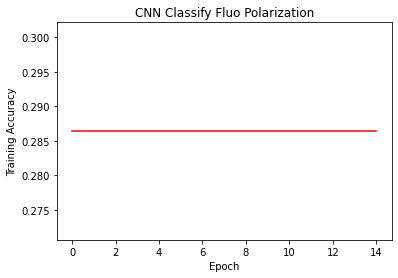

In [21]:
plt.figure()
plt.plot(np.arange(0,epochs,1),train_acc_lst,'r')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.title('CNN Classify Fluo Polarization')
plt.show()

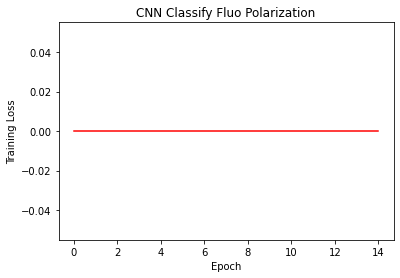

In [22]:
plt.figure()
plt.plot(np.arange(0,epochs,1),train_loss_lst,'r')
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.title('CNN Classify Fluo Polarization')
plt.show()

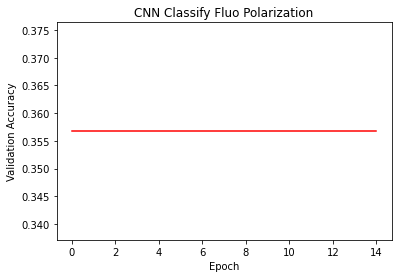

In [23]:
plt.figure()
plt.plot(np.arange(0,epochs,1),val_acc_lst,'r')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.title('CNN Classify Fluo Polarization')
plt.show()